In [366]:
import itertools
import re
from collections import Counter
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.feature_selection import ColumnSelector
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns


%matplotlib inline

In [367]:
source_path = "../data/ml-latest-small"

# Обработка данных

### Обработка movies.csv

In [368]:
movies_df = pd.read_csv(f"{source_path}/movies.csv")
movies_df.sample(5)

,movieId,title,genres
1276,1693,Amistad (1997),Drama|Mystery
6640,56389,My Blueberry Nights (2007),Drama|Romance
7650,88267,Winnie the Pooh (2011),Animation|Children|Comedy
4539,6732,"Hello, Dolly! (1969)",Comedy|Musical|Romance
8991,139415,Irrational Man (2015),Crime|Drama


In [369]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [370]:
movies_df.rename({
    "movieId": "movie_id"
}, axis=1, inplace=True)

In [372]:
movies_df["genres"].replace("(no genres listed)", None, regex=False, inplace=True)
movies_df.dropna(inplace=True)

PATTERN_YEAR = re.compile(r"\((\d{4})\)$")

movies_df["year"] = movies_df["title"].str.strip().str.extract(PATTERN_YEAR)
movies_df["year"] = movies_df["year"].fillna(movies_df["year"].median()).astype("int16")

movies_df.drop("title", axis=1, inplace=True)

movies_df.sample(5)

AttributeError: 'NoneType' object has no attribute 'astype'

In [350]:
cv = CountVectorizer(token_pattern="[a-z\-]+", binary=True, dtype="int8")
genres_vectors = cv.fit_transform(movies_df["genres"])
genres_list = cv.get_feature_names_out()
movies_df = pd.concat([
    movies_df.reset_index(drop=True).drop("genres", axis=1),
    pd.DataFrame(genres_vectors.todense(), columns=genres_list)
], axis=1)
movies_df.head(5)

,movie_id,year,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [351]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9708 entries, 0 to 9707
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   movie_id     9708 non-null   int64
 1   year         9708 non-null   int16
 2   action       9708 non-null   int8 
 3   adventure    9708 non-null   int8 
 4   animation    9708 non-null   int8 
 5   children     9708 non-null   int8 
 6   comedy       9708 non-null   int8 
 7   crime        9708 non-null   int8 
 8   documentary  9708 non-null   int8 
 9   drama        9708 non-null   int8 
 10  fantasy      9708 non-null   int8 
 11  film-noir    9708 non-null   int8 
 12  horror       9708 non-null   int8 
 13  imax         9708 non-null   int8 
 14  musical      9708 non-null   int8 
 15  mystery      9708 non-null   int8 
 16  romance      9708 non-null   int8 
 17  sci-fi       9708 non-null   int8 
 18  thriller     9708 non-null   int8 
 19  war          9708 non-null   int8 
 20  western 

In [352]:
del genres_vectors

### Обработка tags.csv

In [353]:
tags_df = pd.read_csv(f"{source_path}/tags.csv")
tags_df.sample(5)

,userId,movieId,tag,timestamp
1189,474,899,movie business,1137181713
624,327,2616,comic book,1234789098
1123,474,500,men in drag,1137374967
160,62,38061,Robert Downey Jr.,1532723408
2326,474,8183,In Netflix queue,1137201001


In [354]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [355]:
tags_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
tags_df.drop("timestamp", axis=1, inplace=True)
tags_df.dropna(inplace=True)
tags_df.sample(5)

,user_id,movie_id,tag
3496,599,296,nonlinear narrative
498,184,2579,directorial debut
2190,474,6791,Food
2481,474,40815,Magic
2283,474,7572,cancer


In [356]:
PATTERN_CAPS = re.compile(r"[A-Z]+( [A-Z]+)+")
PATTERN_NETFLIX = re.compile(r"^in netflix queue$", flags=re.I)
PATTERN_BASED = re.compile(r"^based on a .*", flags=re.I)
PATTERN_ALPHA = re.compile(r"^[a-z\-]*$", flags=re.I)
PATTERN_ACTOR = re.compile(r"^[A-Z][A-Za-z]+( [A-Z][A-Za-z]+)+$")

tags_df["tag"] = tags_df["tag"].str.strip()
tags_df["tag"].replace("[\.\(\)( - )]", "", regex=True, inplace=True)
tags_df["tag"] = tags_df["tag"].str.replace("/", " ", regex=False)
mask_caps = tags_df["tag"].str.match(PATTERN_CAPS)
tags_df.loc[mask_caps, "tag"] = tags_df.loc[mask_caps, "tag"].str.lower()
mask_phrase = (tags_df["tag"].str.match(PATTERN_BASED) |
               tags_df["tag"].str.match(PATTERN_ACTOR) |
               tags_df["tag"].str.match(PATTERN_NETFLIX))
tags_df.loc[mask_phrase, "tag"] = tags_df.loc[mask_phrase, "tag"].str.replace(" ", "-")
mask_len = tags_df["tag"].map(lambda t: len(t) == 1)
tags_df.loc[mask_len, "tag"] = None
tags_df["tag"] = tags_df["tag"].str.lower()

tags_df = tags_df.groupby(["user_id", "movie_id"], as_index=False).agg(" ".join)
tags_df.sample(5)

,user_id,movie_id,tag
200,357,7078,bettedavis oscarbestactress
445,474,748,aliens
1759,573,52712,horribleacting interesting
1208,474,6281,crime
249,424,3911,satire


In [357]:
cv = CountVectorizer(
    token_pattern="[\da-z\-]+", stop_words="english",
    max_features=500, min_df=5, max_df=0.7,
    binary=True, dtype="int8"
)
tags_vectors = cv.fit_transform(tags_df["tag"])
tags_list = cv.get_feature_names_out()
tags_df = pd.concat([
    tags_df.reset_index(drop=True).drop("tag", axis=1),
    pd.DataFrame(tags_vectors.todense(), columns=tags_list)
], axis=1)
tags_df.sample(5)

,user_id,movie_id,aardman,action,adamsandler,adolescence,adultery,adventure,africa,alcoholism,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
379,474,361,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,119,120635,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
694,474,1663,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
732,474,1957,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1615,537,80906,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

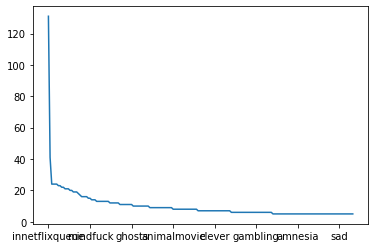

In [364]:
tags_df.drop(["user_id", "movie_id"], axis=1).sum().sort_values(ascending=False).plot()

In [314]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Columns: 186 entries, user_id to zombies
dtypes: int64(2), int8(184)
memory usage: 346.8 KB


In [315]:
del tags_vectors

### Обработка ratings.csv

In [316]:
ratings_df = pd.read_csv(f"{source_path}/ratings.csv")
ratings_df.sample(5)

,userId,movieId,rating,timestamp
82202,521,805,4.0,852713294
79659,495,47997,4.5,1458636803
79163,490,6365,2.5,1324371120
23008,156,3473,5.0,953534555
29380,202,6,5.0,974918622


In [317]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [318]:
ratings_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
ratings_df.drop("timestamp", axis=1, inplace=True)
ratings_df["rating"] = ratings_df["rating"].astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating
22521,153,45720,0
93514,599,2808,2
44796,298,4248,0
52052,339,1231,5
2998,20,720,5


In [319]:
ratings_df["rating_binary"] = (ratings_df["rating"] >= 4).astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary
37824,256,33004,4,1
94886,599,95965,4,1
39434,274,1222,4,1
94885,599,95873,2,0
63185,414,2616,3,0


In [320]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   user_id        100836 non-null  int64
 1   movie_id       100836 non-null  int64
 2   rating         100836 non-null  int8 
 3   rating_binary  100836 non-null  int8 
dtypes: int64(2), int8(2)
memory usage: 1.7 MB


# Подготовка данных для моделей

### Модель жанров

In [321]:
movies_ratings_df = pd.merge(
    ratings_df,
    movies_df,
    on="movie_id"
)

movies_ratings_df["views_count"] = movies_ratings_df.groupby('movie_id')["user_id"].transform('count')
movies_ratings_df["rating_mean"] = movies_ratings_df.groupby('movie_id')["rating"].transform('mean')

movies_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,year,action,adventure,animation,children,comedy,...,imax,musical,mystery,romance,sci-fi,thriller,war,western,views_count,rating_mean
49607,560,3000,4,1,1997,1,1,1,0,0,...,0,0,0,0,0,0,0,0,48,3.833333
2000,343,296,4,1,1994,0,0,0,0,1,...,0,0,0,0,0,1,0,0,307,4.097720
19648,176,368,4,1,1994,0,1,0,0,1,...,0,0,0,0,0,0,0,1,74,3.445946
27297,414,5,2,0,1995,0,0,0,0,1,...,0,0,0,0,0,0,0,0,49,3.000000
55835,200,60074,3,0,2008,1,1,0,0,1,...,0,0,0,0,0,0,0,0,29,2.827586


In [322]:
users_genres_df = pd.concat([
    movies_ratings_df["user_id"].copy(),
    movies_ratings_df[genres_list].mul(movies_ratings_df["rating"], axis=0)
], axis=1)

users_genres_df = users_genres_df.groupby("user_id")[genres_list].mean()

users_genres_df.sample(5)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
user_id,,,,,,,,,,,,,,,,,,,
70,0.225806,0.532258,0.064516,0.290323,1.177419,0.467742,0.129032,3.467742,0.290323,0.000000,0.064516,0.064516,0.000000,0.112903,0.967742,0.387097,0.129032,0.338710,0.064516
566,1.027027,0.878378,0.081081,0.135135,1.500000,0.445946,0.000000,1.662162,0.256757,0.000000,0.067568,0.067568,0.081081,0.175676,1.243243,0.445946,1.054054,0.364865,0.202703
254,1.165354,0.984252,0.196850,0.251969,0.763780,0.992126,0.125984,1.968504,0.307087,0.070866,0.251969,0.118110,0.062992,0.574803,0.519685,0.732283,1.496063,0.244094,0.031496
481,0.806452,0.258065,0.000000,0.129032,0.419355,0.612903,0.000000,1.451613,0.000000,0.161290,0.129032,0.000000,0.000000,0.580645,0.677419,0.451613,1.096774,0.129032,0.000000
470,1.175000,0.925000,0.175000,0.362500,1.250000,0.700000,0.000000,1.562500,0.412500,0.000000,0.037500,0.125000,0.175000,0.187500,0.812500,0.387500,1.287500,0.312500,0.100000


In [323]:
genres_model_df = pd.merge(
    movies_ratings_df[ ["user_id", "movie_id", "year", "rating", "rating_mean", "views_count"]],
    users_genres_df,
    on="user_id",
)

genres_model_df["rating_binary"] = (genres_model_df["rating"] >= 4).astype("int8")
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
49691,528,6874,2003,3,3.725191,131,1.369863,0.575342,0.136986,0.095890,...,0.109589,0.397260,0.000000,0.287671,0.273973,0.301370,1.301370,0.219178,0.000000,0
50105,534,45186,2006,4,3.392857,28,1.984615,1.705769,0.600000,0.586538,...,0.240385,0.500000,0.163462,0.146154,0.400000,1.088462,0.851923,0.125000,0.046154,1
59765,603,2940,1946,4,4.000000,6,0.515376,0.330859,0.009544,0.053022,...,0.281018,0.000000,0.119830,0.291622,0.790032,0.269353,0.731707,0.115589,0.079533,1
77994,230,1704,1997,3,3.929078,141,1.194245,1.043165,0.316547,0.417266,...,0.302158,0.237410,0.172662,0.151079,0.489209,0.654676,0.848921,0.028777,0.014388,0
37325,414,2264,1989,3,2.750000,4,0.791543,0.566024,0.170252,0.220326,...,0.147997,0.074184,0.137240,0.193620,0.623145,0.397255,0.741098,0.172849,0.067507,0


In [324]:
genres_model_df.isna().sum()

user_id          0
movie_id         0
year             0
rating           0
rating_mean      0
views_count      0
action           0
adventure        0
animation        0
children         0
comedy           0
crime            0
documentary      0
drama            0
fantasy          0
film-noir        0
horror           0
imax             0
musical          0
mystery          0
romance          0
sci-fi           0
thriller         0
war              0
western          0
rating_binary    0
dtype: int64

In [325]:
genres_model_df.dropna(axis=1, how="all", inplace=True)
genres_model_df.fillna(genres_model_df.median(), inplace=True)
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
14883,182,3438,1990,3,2.880000,25,0.768680,0.504606,0.104401,0.083930,...,0.169908,0.016377,0.070624,0.289662,0.563971,0.453429,0.890481,0.232344,0.034800,0
36061,414,2990,1989,3,3.250000,20,0.791543,0.566024,0.170252,0.220326,...,0.147997,0.074184,0.137240,0.193620,0.623145,0.397255,0.741098,0.172849,0.067507,0
27588,298,7150,2003,1,2.600000,10,0.714590,0.535676,0.155485,0.060703,...,0.104366,0.143770,0.033014,0.138445,0.284345,0.518637,0.445154,0.052183,0.023429,0
89235,265,788,1996,3,2.621951,82,0.969325,0.828221,0.000000,0.110429,...,0.177914,0.024540,0.055215,0.134969,0.521472,1.392638,0.754601,0.220859,0.073620,0
82134,452,4015,2000,5,2.545455,33,2.475248,1.455446,0.069307,0.069307,...,0.519802,0.000000,0.069307,0.514851,0.465347,1.376238,1.886139,0.222772,0.019802,1


In [326]:
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100789 entries, 0 to 100788
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100789 non-null  int64  
 1   movie_id       100789 non-null  int64  
 2   year           100789 non-null  int16  
 3   rating         100789 non-null  int8   
 4   rating_mean    100789 non-null  float64
 5   views_count    100789 non-null  int64  
 6   action         100789 non-null  float64
 7   adventure      100789 non-null  float64
 8   animation      100789 non-null  float64
 9   children       100789 non-null  float64
 10  comedy         100789 non-null  float64
 11  crime          100789 non-null  float64
 12  documentary    100789 non-null  float64
 13  drama          100789 non-null  float64
 14  fantasy        100789 non-null  float64
 15  film-noir      100789 non-null  float64
 16  horror         100789 non-null  float64
 17  imax           100789 non-nul

In [327]:
dtypes_df = genres_model_df.select_dtypes(["float64", "float32"])
genres_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100789 entries, 0 to 100788
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100789 non-null  int64  
 1   movie_id       100789 non-null  int64  
 2   year           100789 non-null  int16  
 3   rating         100789 non-null  int8   
 4   rating_mean    100789 non-null  float16
 5   views_count    100789 non-null  int64  
 6   action         100789 non-null  float16
 7   adventure      100789 non-null  float16
 8   animation      100789 non-null  float16
 9   children       100789 non-null  float16
 10  comedy         100789 non-null  float16
 11  crime          100789 non-null  float16
 12  documentary    100789 non-null  float16
 13  drama          100789 non-null  float16
 14  fantasy        100789 non-null  float16
 15  film-noir      100789 non-null  float16
 16  horror         100789 non-null  float16
 17  imax           100789 non-nul

In [328]:
del movies_df, movies_ratings_df, users_genres_df

In [329]:
genres_model_df[["year", "rating", "rating_mean", "views_count"]].describe()

,year,rating,rating_mean,views_count
count,100789.000000,100789.000000,100789.000000,100789.000000
mean,1994.440643,3.350872,NaN,58.782159
std,14.358357,1.089178,0.000000,61.969076
min,1902.000000,0.000000,0.000000,1.000000
25%,1990.000000,3.000000,3.000000,13.000000
50%,1997.000000,3.000000,3.435547,39.000000
75%,2003.000000,4.000000,3.759766,84.000000
max,2018.000000,5.000000,5.000000,329.000000


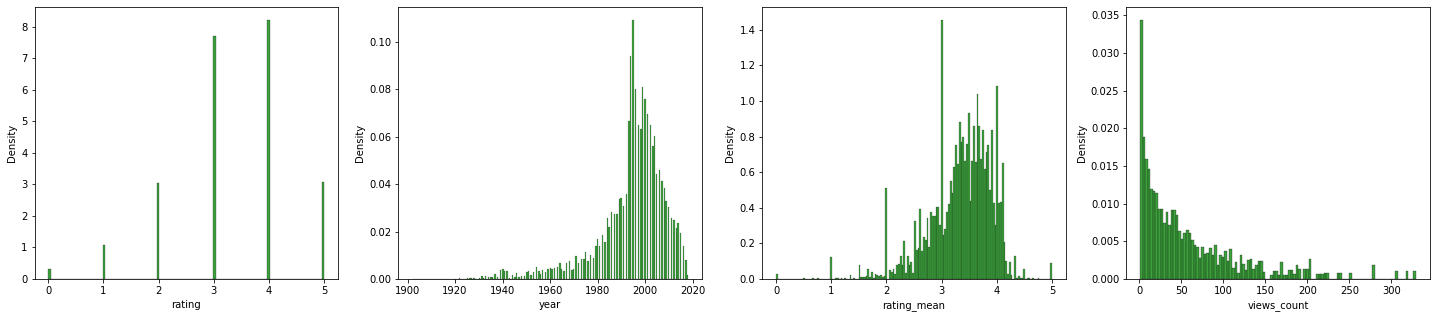

In [330]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for i, feature in enumerate(genres_model_df[["rating", "year", "rating_mean", "views_count"]]):
    sns.histplot(genres_model_df[feature], color="green", stat="density", ax=ax[i])

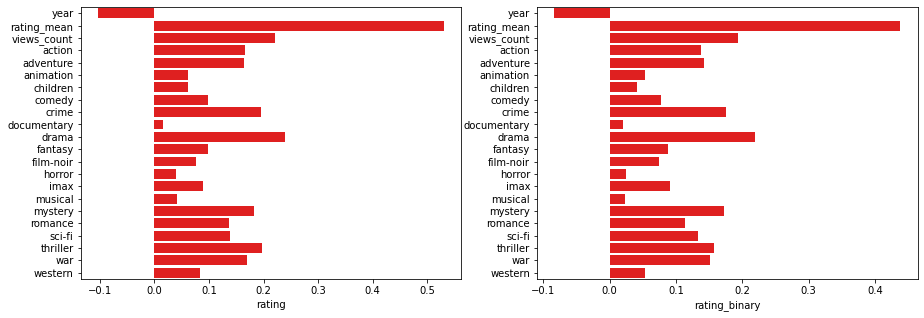

In [331]:
corr = genres_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

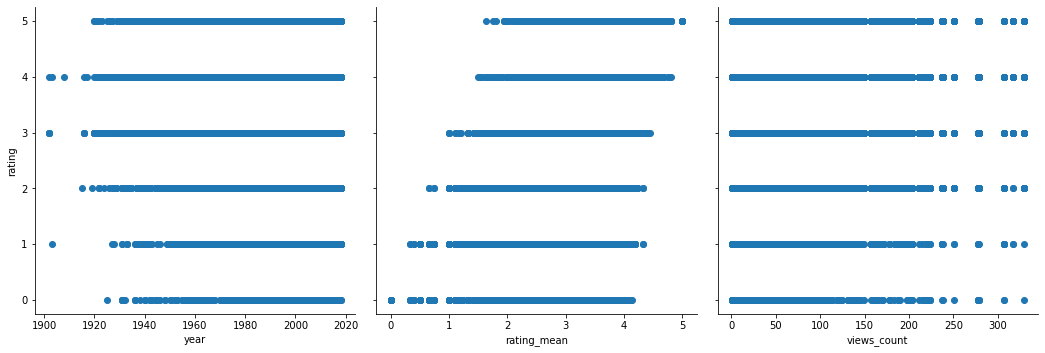

In [332]:
pg = sns.PairGrid(
    genres_model_df,
    x_vars=["year", "rating_mean", "views_count"],
    y_vars="rating",
    height=5,
)

pg.map(plt.scatter)

### Модель тэгов

In [333]:
tags_ratings_df = pd.merge(
    ratings_df.set_index(["user_id", "movie_id"]),
    tags_df.set_index(["user_id", "movie_id"]),
    on=["user_id", "movie_id"]
).reset_index()

tags_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
746,474,2300,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1500,537,97304,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431,474,907,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252,424,104879,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,474,1101,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [334]:
users_tags_df = pd.concat([
    tags_ratings_df["user_id"].copy(),
    tags_ratings_df[tags_list].mul(tags_ratings_df["rating"], axis=0)
], axis=1)
users_tags_df.replace(0, None, inplace=True)

users_tags_df = users_tags_df.groupby("user_id")[tags_list].mean()
users_tags_df.sample(5)

,aardman,action,adamsandler,adolescence,adultery,adventure,africa,alcoholism,aliens,alpacino,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
user_id,,,,,,,,,,,,,,,,,,,,,
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
tags_model_df = pd.merge(
    tags_ratings_df[["user_id", "movie_id", "rating", "rating_binary"]],
    users_tags_df,
    on="user_id"
)

tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
1091,474,5952,5,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
1077,474,5682,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
562,474,1246,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
874,474,3258,2,0,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5
503,474,1089,4,1,3.8,NaN,NaN,3.818182,3.545455,NaN,...,3.3,3.75,NaN,NaN,3.0,NaN,NaN,4.5,3.0,3.5


In [336]:
tags_model_df.isna().sum()

user_id             0
movie_id            0
rating              0
rating_binary       0
aardman           486
                 ... 
willferrell      1505
witty            1328
wizards           486
worldwarii        411
zombies           412
Length: 188, dtype: int64

In [337]:
tags_model_df.dropna(axis=1, how="all", inplace=True)
tags_model_df.fillna(tags_model_df.median(), inplace=True)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,aardman,action,adamsandler,adolescence,adultery,adventure,...,vietnam,violence,visuallyappealing,visuallystunning,wedding,willferrell,witty,wizards,worldwarii,zombies
951,474,4025,2,0,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.0,3.0,3.75,3.0,4.5,3.0,3.5
623,474,1407,4,1,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.0,3.0,3.75,3.0,4.5,3.0,3.5
775,474,2471,1,0,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.0,3.0,3.75,3.0,4.5,3.0,3.5
1076,474,5673,4,1,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.0,3.0,3.75,3.0,4.5,3.0,3.5
980,474,4296,2,0,3.8,3.8,4.0,3.818182,3.545455,4.0,...,3.3,3.75,3.538462,4.0,3.0,3.75,3.0,4.5,3.0,3.5


In [338]:
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 0 to 1634
Columns: 188 entries, user_id to zombies
dtypes: float64(184), int64(2), int8(2)
memory usage: 2.3 MB


In [339]:
dtypes_df = tags_model_df.select_dtypes(["float64", "float32"])
tags_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 0 to 1634
Columns: 188 entries, user_id to zombies
dtypes: float16(184), int64(2), int8(2)
memory usage: 629.1 KB


In [340]:
del tags_df, tags_ratings_df, users_tags_df

<AxesSubplot:xlabel='rating', ylabel='Density'>

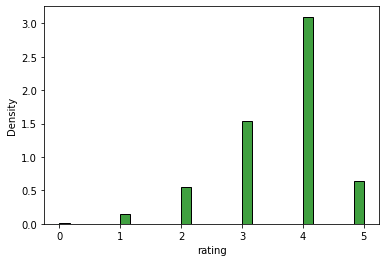

In [341]:
sns.histplot(tags_model_df["rating"], color="green", stat="density")

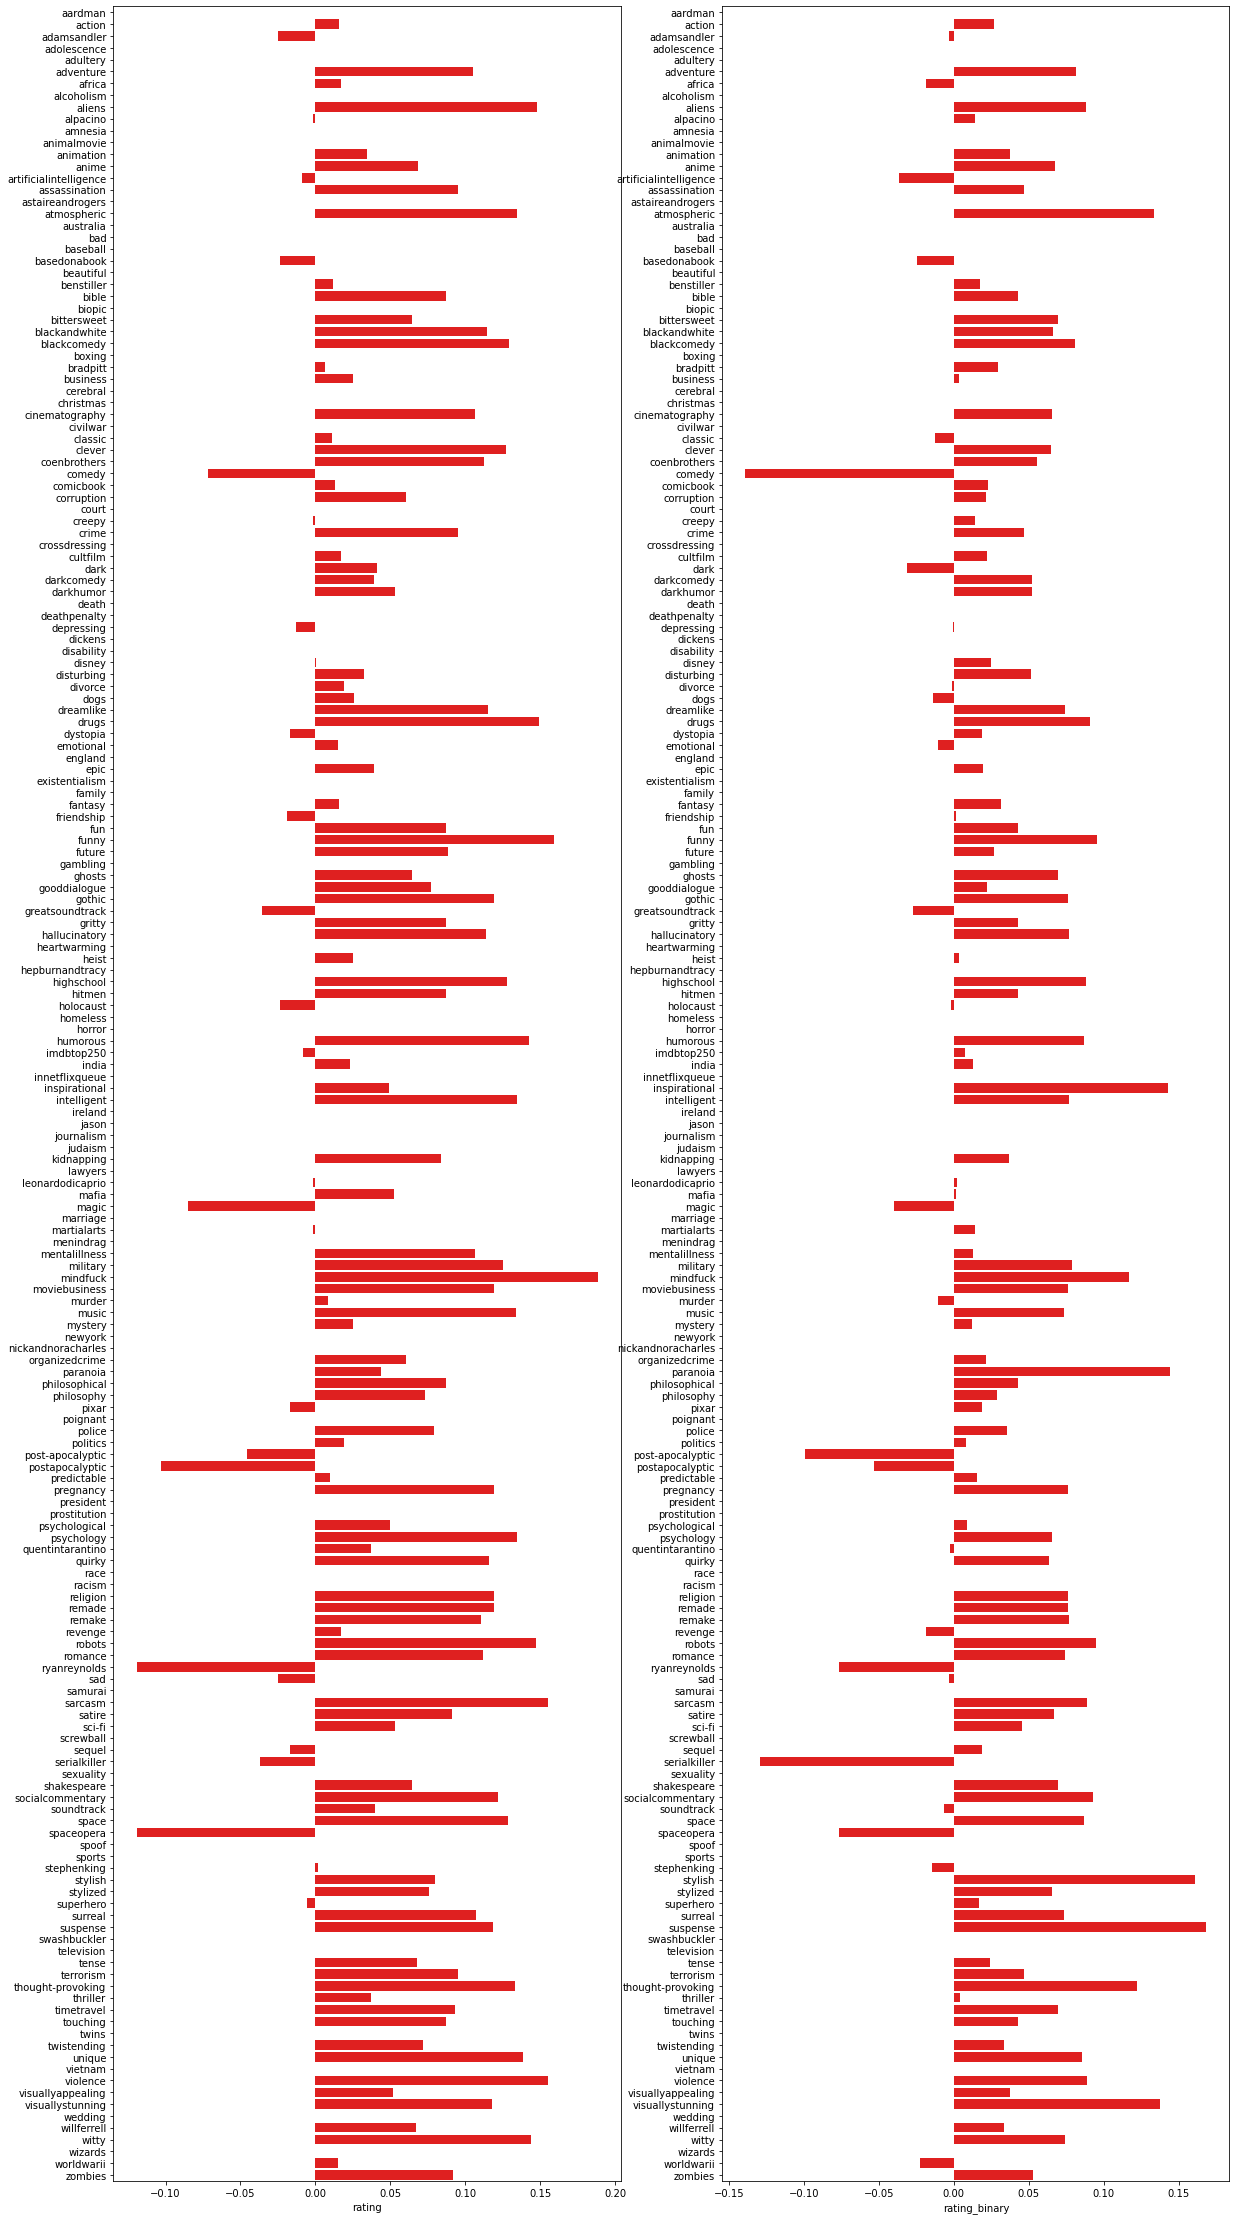

In [342]:
corr = tags_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"]).sample(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 40))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

## Финальная модель

In [343]:
genres_model_renamed_df = genres_model_df.add_suffix("_genres")
tags_model_renamed_df = tags_model_df.add_suffix("_tags")

final_model_df = pd.merge(
    genres_model_renamed_df.set_index(["user_id_genres", "movie_id_genres"]),
    tags_model_renamed_df.set_index(["user_id_tags", "movie_id_tags"]),
    left_on=["user_id_genres", "movie_id_genres"],
    right_on=["user_id_tags", "movie_id_tags"],
)
final_model_df.sample(5)

,year_genres,rating_genres,rating_mean_genres,views_count_genres,action_genres,adventure_genres,animation_genres,children_genres,comedy_genres,crime_genres,...,vietnam_tags,violence_tags,visuallyappealing_tags,visuallystunning_tags,wedding_tags,willferrell_tags,witty_tags,wizards_tags,worldwarii_tags,zombies_tags
1115,1964,4,4.000000,1,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
513,1996,4,3.042969,70,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
1578,2000,5,3.699219,30,1.111328,0.710449,0.281250,0.186646,1.506836,0.565430,...,3.300781,5.00,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
944,2003,3,3.000000,4,0.325928,0.401855,0.126221,0.190674,1.085938,0.375732,...,3.300781,3.75,3.539062,4.0,3.0,3.75,3.0,4.5,3.0,3.5
1255,2009,3,2.250000,20,1.044922,0.973145,0.495117,0.439941,1.453125,0.366699,...,3.300781,3.75,4.000000,5.0,3.0,3.75,4.0,4.5,3.0,4.0


In [215]:
final_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Columns: 211 entries, index to zombies_tags
dtypes: float16(204), int16(1), int64(2), int8(4)
memory usage: 686.3 KB


# Моделирование

In [216]:
def display_report(y_test: np.ndarray, y_pred: np.ndarray):
    class_names = set(y_test)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    print(metrics.classification_report(y_test, y_pred, zero_division=0))

## Мультиклассовые модели

### Модель жанров

In [231]:
x = genres_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = genres_model_df.drop("user_id", axis=1)["rating"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

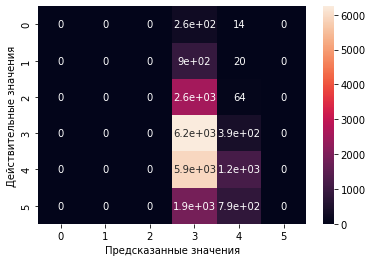

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       273
           1       0.00      0.00      0.00       920
           2       0.00      0.00      0.00      2619
           3       0.35      0.94      0.51      6634
           4       0.48      0.16      0.24      7071
           5       0.00      0.00      0.00      2641

    accuracy                           0.37     20158
   macro avg       0.14      0.18      0.13     20158
weighted avg       0.28      0.37      0.25     20158



In [952]:
gnb = GaussianNB(var_smoothing=7)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 1000, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

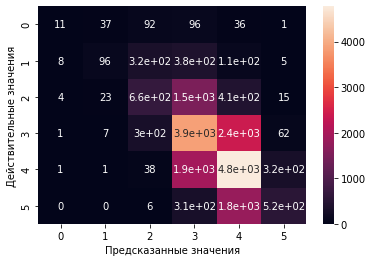

              precision    recall  f1-score   support

           0       0.44      0.04      0.07       273
           1       0.59      0.10      0.18       920
           2       0.47      0.25      0.33      2619
           3       0.48      0.58      0.52      6634
           4       0.50      0.68      0.58      7071
           5       0.57      0.20      0.29      2641

    accuracy                           0.49     20158
   macro avg       0.51      0.31      0.33     20158
weighted avg       0.50      0.49      0.46     20158



In [110]:
lr = LogisticRegression(C=122, tol=10, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

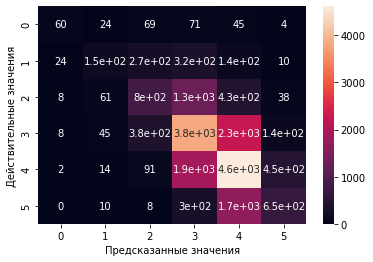

              precision    recall  f1-score   support

           0       0.59      0.22      0.32       273
           1       0.50      0.16      0.25       920
           2       0.50      0.31      0.38      2619
           3       0.50      0.58      0.53      6634
           4       0.50      0.65      0.57      7071
           5       0.50      0.25      0.33      2641

    accuracy                           0.50     20158
   macro avg       0.51      0.36      0.40     20158
weighted avg       0.50      0.50      0.48     20158



In [235]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

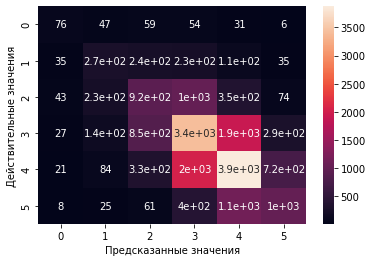

              precision    recall  f1-score   support

           0       0.36      0.28      0.31       273
           1       0.34      0.30      0.32       920
           2       0.37      0.35      0.36      2619
           3       0.48      0.51      0.50      6634
           4       0.52      0.55      0.54      7071
           5       0.47      0.38      0.42      2641

    accuracy                           0.47     20158
   macro avg       0.42      0.39      0.41     20158
weighted avg       0.47      0.47      0.47     20158



In [234]:
rfc = RandomForestClassifier(max_depth=40, n_estimators=10, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

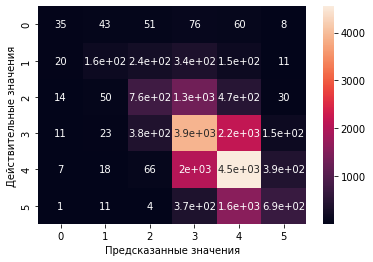

              precision    recall  f1-score   support

           0       0.40      0.13      0.19       273
           1       0.52      0.17      0.26       920
           2       0.51      0.29      0.37      2619
           3       0.49      0.59      0.53      6634
           4       0.51      0.64      0.57      7071
           5       0.54      0.26      0.35      2641

    accuracy                           0.50     20158
   macro avg       0.49      0.35      0.38     20158
weighted avg       0.50      0.50      0.48     20158



In [958]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
svc = LinearSVC(max_iter=10000)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [[30] * 5, [30] * 10, [30] * 30],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

C:\Users\derbi\Projects\PyCharm\course-work\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


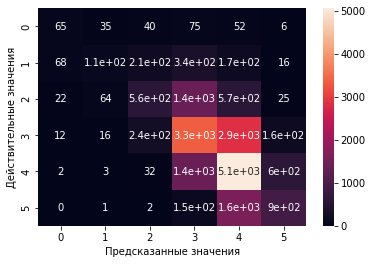

              precision    recall  f1-score   support

           0       0.38      0.24      0.29       273
           1       0.48      0.12      0.19       920
           2       0.51      0.21      0.30      2619
           3       0.50      0.50      0.50      6634
           4       0.49      0.72      0.58      7071
           5       0.53      0.34      0.41      2641

    accuracy                           0.50     20158
   macro avg       0.48      0.36      0.38     20158
weighted avg       0.50      0.50      0.48     20158



In [233]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Модель тэгов

In [112]:
x = tags_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = tags_model_df.drop("user_id", axis=1)["rating"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
gnb = GaussianNB(var_smoothing=6)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 1000, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

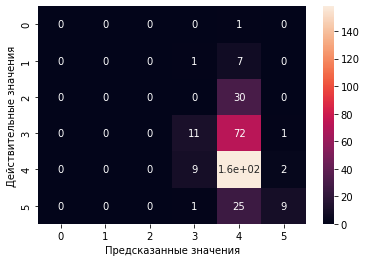

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.50      0.13      0.21        84
           4       0.54      0.93      0.68       169
           5       0.75      0.26      0.38        35

    accuracy                           0.54       327
   macro avg       0.30      0.22      0.21       327
weighted avg       0.49      0.54      0.45       327



In [114]:
lr = LogisticRegression(C=408, tol=27, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

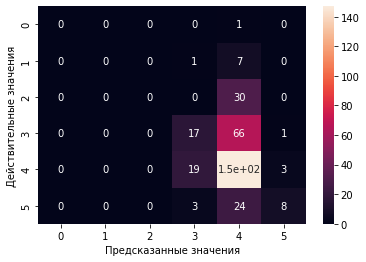

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.42      0.20      0.27        84
           4       0.53      0.87      0.66       169
           5       0.67      0.23      0.34        35

    accuracy                           0.53       327
   macro avg       0.27      0.22      0.21       327
weighted avg       0.46      0.53      0.45       327



In [115]:
dtc = DecisionTreeClassifier(max_depth=40)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

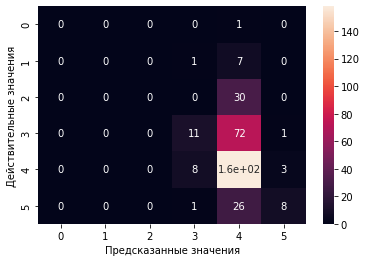

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        30
           3       0.52      0.13      0.21        84
           4       0.54      0.93      0.68       169
           5       0.67      0.23      0.34        35

    accuracy                           0.54       327
   macro avg       0.29      0.22      0.21       327
weighted avg       0.48      0.54      0.44       327



In [116]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
svc = LinearSVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Финальная модель

In [373]:
x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y = final_model_df["rating_genres"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

genres_columns = list(
    genres_model_renamed_df.drop(["user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"],
                                 axis=1).columns)
tags_columns = list(
    tags_model_renamed_df.drop(["user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"], axis=1).columns)

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

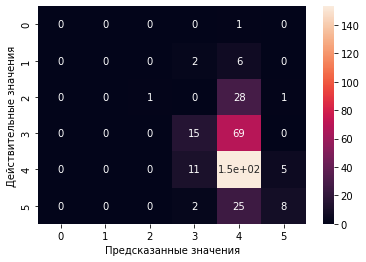

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       1.00      0.03      0.06        30
           3       0.50      0.18      0.26        84
           4       0.54      0.91      0.68       169
           5       0.57      0.23      0.33        35

    accuracy                           0.54       327
   macro avg       0.44      0.22      0.22       327
weighted avg       0.56      0.54      0.46       327



In [374]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=30, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

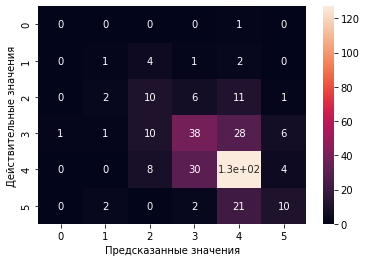

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.17      0.12      0.14         8
           2       0.31      0.33      0.32        30
           3       0.49      0.45      0.47        84
           4       0.67      0.75      0.71       169
           5       0.48      0.29      0.36        35

    accuracy                           0.57       327
   macro avg       0.35      0.32      0.33       327
weighted avg       0.56      0.57      0.56       327



In [375]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

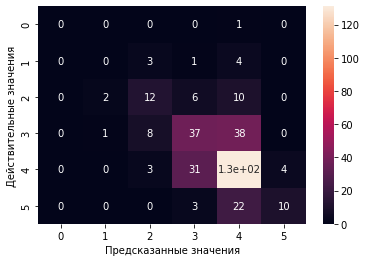

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.46      0.40      0.43        30
           3       0.47      0.44      0.46        84
           4       0.64      0.78      0.70       169
           5       0.71      0.29      0.41        35

    accuracy                           0.58       327
   macro avg       0.38      0.32      0.33       327
weighted avg       0.57      0.58      0.56       327



In [376]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

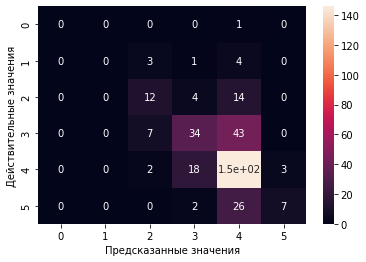

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.50      0.40      0.44        30
           3       0.58      0.40      0.48        84
           4       0.62      0.86      0.72       169
           5       0.70      0.20      0.31        35

    accuracy                           0.61       327
   macro avg       0.40      0.31      0.33       327
weighted avg       0.59      0.61      0.57       327



In [377]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

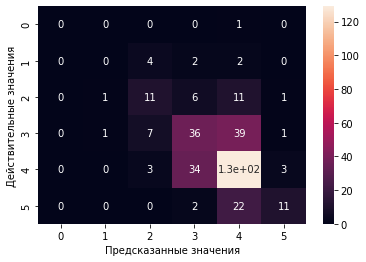

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.44      0.37      0.40        30
           3       0.45      0.43      0.44        84
           4       0.63      0.76      0.69       169
           5       0.69      0.31      0.43        35

    accuracy                           0.57       327
   macro avg       0.37      0.31      0.33       327
weighted avg       0.56      0.57      0.55       327



In [378]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", VotingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=60, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=40, n_estimators=401, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=40)),
        ("lr", LogisticRegression(max_iter=1e7, n_jobs=cpu_count()))
    ], voting="soft", n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

## Бинарные модели

### Модель жанров

In [948]:
x = genres_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = genres_model_df.drop("user_id", axis=1)["rating_binary"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler())
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
gnb = GaussianNB(var_smoothing=0.04)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 100, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
lr = LogisticRegression(max_iter=1e7, C=78, tol=2, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
dtc = DecisionTreeClassifier(max_depth=30)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 500, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
rfc = RandomForestClassifier(max_depth=11, n_estimators=200, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
knc = KNeighborsClassifier(leaf_size=11, n_neighbors=50, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
svc = LinearSVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Модель тэгов

In [ ]:
x = tags_model_df.drop(["user_id", "movie_id", "rating", "rating_binary"], axis=1)
y = tags_model_df.drop("user_id", axis=1)["rating_binary"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [ ]:
hgs = HalvingGridSearchCV(
    GaussianNB(),
    {
        "var_smoothing": np.linspace(10, 1e-9, 1000),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
gnb = GaussianNB(var_smoothing=0.04)
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    LogisticRegression(max_iter=1e7),
    {
        "C": np.linspace(1e-5, 100, 50),
        "tol": np.linspace(1e-5, 100, 50)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
lr = LogisticRegression(max_iter=1e7, C=78, tol=2, n_jobs=cpu_count())
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    DecisionTreeClassifier(),
    {
        "max_depth": range(1, 30),
    },
    cv=5, verbose=1, min_resources=50000, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
dtc = DecisionTreeClassifier(max_depth=30)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    RandomForestClassifier(),
    {
        "n_estimators": range(1, 1000, 100),
        "max_depth": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    KNeighborsClassifier(),
    {
        "n_neighbors": range(10, 100, 10),
        "leaf_size": range(1, 30, 10),
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
knc = KNeighborsClassifier(leaf_size=21, n_neighbors=60, n_jobs=cpu_count())
knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    SVC(),
    {
        "C": np.linspace(1e-3, 1000),
        "kernel": ["rbf", "poly", "linear", "sigmoid"],
        "tol": np.linspace(1e-3, 1000)
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
svc = LinearSVC(max_iter=1e6)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
hgs = HalvingGridSearchCV(
    MLPClassifier(max_iter=1000),
    {
        "hidden_layer_sizes": [(10,), (10, 10, 10), (40,), (40, 40, 40)],
    },
    cv=5, verbose=1, n_jobs=cpu_count()
)
hgs.fit(x_train, y_train)
print(hgs.best_params_, hgs.best_score_)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=[30] * 5, max_iter=1000)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
display_report(y_test, y_pred)

### Финальная модель

In [248]:
x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y = final_model_df["rating_binary_tags"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

genres_columns = list(
    genres_model_renamed_df.drop(["user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"],
                                 axis=1).columns)
tags_columns = list(
    tags_model_renamed_df.drop(["user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"], axis=1).columns)

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

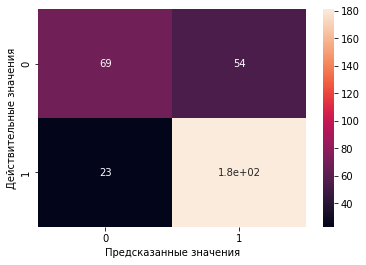

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       123
           1       0.77      0.89      0.82       204

    accuracy                           0.76       327
   macro avg       0.76      0.72      0.73       327
weighted avg       0.76      0.76      0.76       327



In [250]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=30, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
dtc = DecisionTreeClassifier(max_depth=40)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
display_report(y_test, y_pred)

In [ ]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=401, n_jobs=cpu_count())
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
display_report(y_test, y_pred)

# Тестирование

In [ ]:
genres_model_renamed_df = genres_model_df.add_suffix("_genres")
tags_model_renamed_df = tags_model_df.add_suffix("_tags")

final_model_df = pd.merge(
    genres_model_renamed_df.set_index(["user_id_genres", "movie_id_genres"]),
    tags_model_renamed_df.set_index(["user_id_tags", "movie_id_tags"]),
    left_on=["user_id_genres", "movie_id_genres"],
    right_on=["user_id_tags", "movie_id_tags"],
)
final_model_df.sample(5)

In [253]:
final_model_df["user_id_genres"]

KeyError: 'user_id_genres'